## Introduction

In [144]:
import pandas as pd
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np
import seaborn as sns

from sklearn.feature_selection import RFECV

In [145]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [146]:
train = process_age(train)
holdout = process_age(holdout)

cols = ["Age_categories", "Pclass", "Sex"]
for col in cols:
    train = create_dummies(train, col)
    holdout = create_dummies(holdout, col)

In [147]:
train.isnull().sum()

PassengerId                     0
Survived                        0
Pclass                          0
Name                            0
Sex                             0
Age                             0
SibSp                           0
Parch                           0
Ticket                          0
Fare                            0
Cabin                         687
Embarked                        2
Age_categories                  0
Age_categories_Missing          0
Age_categories_Infant           0
Age_categories_Child            0
Age_categories_Teenager         0
Age_categories_Young Adult      0
Age_categories_Adult            0
Age_categories_Senior           0
Pclass_1                        0
Pclass_2                        0
Pclass_3                        0
Sex_female                      0
Sex_male                        0
dtype: int64

In [148]:
holdout.isnull().sum()

PassengerId                     0
Pclass                          0
Name                            0
Sex                             0
Age                             0
SibSp                           0
Parch                           0
Ticket                          0
Fare                            1
Cabin                         327
Embarked                        0
Age_categories                  0
Age_categories_Missing          0
Age_categories_Infant           0
Age_categories_Child            0
Age_categories_Teenager         0
Age_categories_Young Adult      0
Age_categories_Adult            0
Age_categories_Senior           0
Pclass_1                        0
Pclass_2                        0
Pclass_3                        0
Sex_female                      0
Sex_male                        0
dtype: int64

## Preparing More Features

Here is a list of the remaining columns (with a brief description), followed by 10 randomly selected passengers from and their data from those columns, so we can refamiliarize ourselves with the data.

* SibSp - The number of siblings or spouses the passenger had aboard the Titanic
* Parch - The number of parents or children the passenger had aboard the Titanic
* Ticket - The passenger's ticket number
* Fare - The fair the passenger paid
* Cabin - The passengers cabin number
* Embarked - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

In [149]:
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
print(train[columns].describe(include='all',percentiles=[]))

             SibSp       Parch        Fare    Cabin Embarked
count   891.000000  891.000000  891.000000      204      889
unique         NaN         NaN         NaN      147        3
top            NaN         NaN         NaN  B96 B98        S
freq           NaN         NaN         NaN        4      644
mean      0.523008    0.381594   32.204208      NaN      NaN
std       1.102743    0.806057   49.693429      NaN      NaN
min       0.000000    0.000000    0.000000      NaN      NaN
50%       0.000000    0.000000   14.454200      NaN      NaN
max       8.000000    6.000000  512.329200      NaN      NaN


Replace any missing values in the Embarked column with "S"

In [150]:
train['Embarked'].fillna('S', inplace=True)

In [151]:
train = create_dummies(train, 'Embarked')

holdout = create_dummies(holdout, 'Embarked')

Normalization of `'SibSp','Parch','Fare'`

In [152]:
columns = ['SibSp','Parch','Fare']

norm_cols = ['SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

for i, col in enumerate(columns):
    train[norm_cols[i]] = minmax_scale(train[col])
    holdout[norm_cols[i]] = minmax_scale(holdout[col])

In [153]:
holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())

## Determining the Most Relevant Features

In [154]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

features = train[columns]
target = train['Survived']

lr = LogisticRegression()
lr.fit(features, target)

coefficients = lr.coef_

In [155]:
coefficients

array([[-0.38592968,  1.83025455,  0.31730727, -0.2179581 , -0.04893957,
        -0.56375719, -0.9309081 ,  0.96685081,  0.05896997, -1.0257516 ,
         1.33811235, -1.33804317,  0.17040381,  0.16809182, -0.33842646,
        -1.75604017, -0.78286642,  0.5356959 ]])

In [156]:
feature_importance = pd.Series(coefficients[0],
                               index=features.columns)

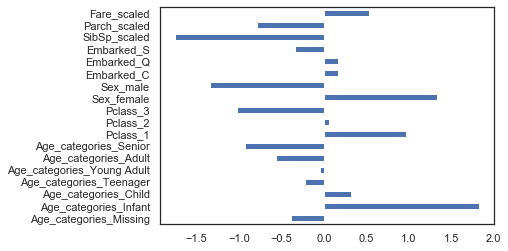

In [157]:
feature_importance.plot.barh();

## Training a model using relevant features.

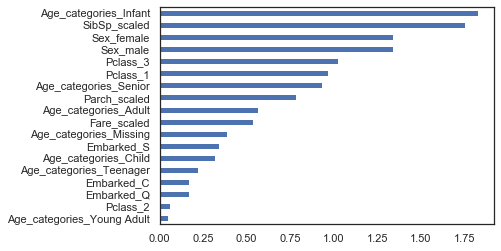

In [158]:
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

We'll train a new model with the **top 8** scores and check our accuracy using cross validation.

In [159]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

lr = LogisticRegression()

scores = cross_val_score(lr, train[columns], train['Survived'], cv=10)

accuracy = np.mean(scores)

In [160]:
print(scores)
print(accuracy)

[0.82222222 0.83146067 0.78651685 0.86516854 0.83146067 0.78651685
 0.79775281 0.76404494 0.84269663 0.82022472]
0.8148064918851435


## Submitting our Improved Model to Kaggle

In [161]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

all_X = train[columns]
all_y = train['Survived']

lr = LogisticRegression()

lr.fit(all_X, all_y)
holdout_predictions = lr.predict(holdout[columns])

In [162]:
submission = pd.DataFrame({'PassengerId': holdout['PassengerId'], 'Survived': holdout_predictions})

submission.to_csv('submission_1.csv', index=False)

## Engineering a New Feature Using Binning

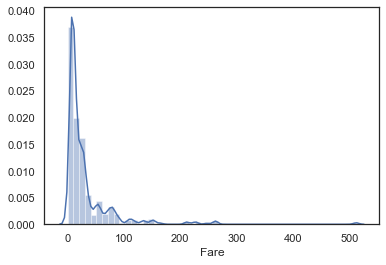

In [163]:
sns.distplot(train['Fare']);

In [164]:
def process_fare(df):
    cut_points = [0,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

In [165]:
train = process_fare(train)
holdout = process_fare(holdout)

In [166]:
train = create_dummies(train, 'Fare_categories')
holdout = create_dummies(holdout, 'Fare_categories')

## Engineering Features From Text Columns

In [167]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)

extracted_titles = holdout["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
holdout["Title"] = extracted_titles.map(titles)

In [168]:
train['Cabin_type'] = train['Cabin'].str[0]
train['Cabin_type'].fillna('Unknown', inplace=True)

In [169]:
holdout['Cabin_type'] = holdout['Cabin'].str[0]
holdout['Cabin_type'].fillna('Unknown', inplace=True)

In [170]:
train = create_dummies(train, 'Title')
holdout = create_dummies(holdout, 'Title')

train = create_dummies(train, 'Cabin_type')
holdout = create_dummies(holdout, 'Cabin_type')

## Finding Correlated Features

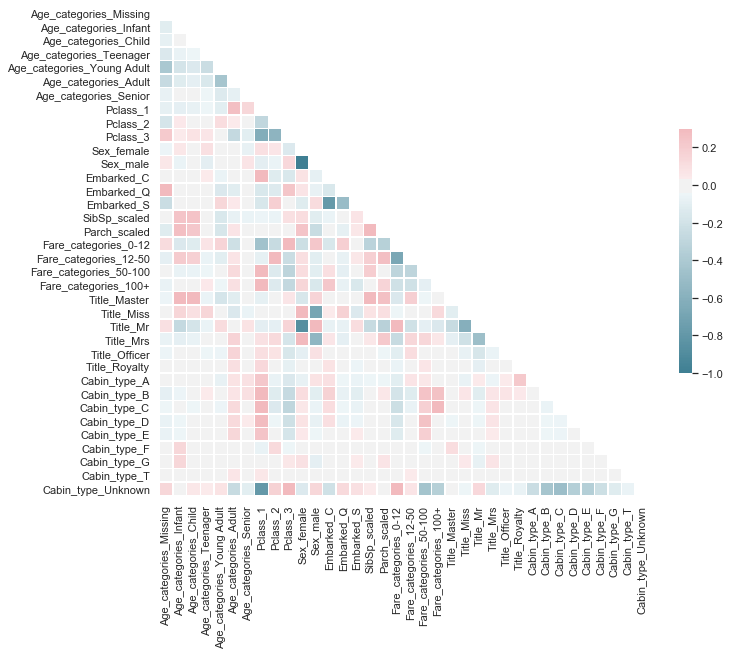

In [171]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

plot_correlation_heatmap(train[columns])

## Final Feature Selection using RFECV

We can see that there is a high correlation between `Sex_female/Sex_male` and `Title_Miss/Title_Mr/Title_Mrs`. We will remove the columns `Sex_female` and `Sex_male` since the title data may be more nuanced.

Apart from that, we should remove one of each of our dummy variables to reduce the collinearity in each. We'll remove:

* `Pclass_2`
* `Age_categories_Teenager`
* `Fare_categories_12-50`
* `Title_Master`
* `Cabin_type_A`

In [172]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']


all_X = train[columns]
all_y = train["Survived"]

lr = LogisticRegression()
selector = RFECV(lr,cv=10)
selector.fit(all_X,all_y)

optimized_columns = all_X.columns[selector.support_]

In [173]:
train['Cabin'].str[0].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

## Training A Model Using our Optimized Columns

In [174]:
all_X = train[optimized_columns]
all_y = train["Survived"]

lr = LogisticRegression()

scores = cross_val_score(lr, train[optimized_columns], train['Survived'], cv=10)

accuracy = np.mean(scores)

In [175]:
accuracy

0.8226591760299625

In [179]:
optimized_columns

Index(['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown'], dtype='object')

## Submitting our Model to Kaggle

In [180]:
lr = LogisticRegression()

lr.fit(train[optimized_columns], train['Survived'])

holdout_predictions = lr.predict(holdout[optimized_columns])

In [181]:
submission = pd.DataFrame({'PassengerId': holdout['PassengerId'], 'Survived': holdout_predictions})

submission.to_csv('submission_2.csv', index=False)